In [1]:
import os
from dotenv import load_dotenv
load_dotenv()

os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")
os.environ["TAVILY_API_KEY"] = os.getenv("TAVILY_API_KEY")

In [2]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import FAISS
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings()

# docs to index
urls = [
    "https://www.langchain.com/docs/get-started/introduction",
    "https://www.langchain.com/docs/get-started/quickstart"
    
]

# Load
docs = [WebBaseLoader(url).load() for url in urls]
doc_list = [item for sublist in docs for item in sublist]

# Split
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)

doc_splits = text_splitter.split_documents(doc_list)

# Add to vector store
vectorstore = FAISS.from_documents(doc_splits, embeddings)

retriever = vectorstore.as_retriever()


USER_AGENT environment variable not set, consider setting it to identify your requests.


In [6]:
## retriever grader
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI

from pydantic import BaseModel, Field

# Data Model
class RetrieverGrader(BaseModel):
    """Binary score for relevance check on retrieved docs"""

    binary_score: str = Field(
        description="Binary score for relevance check on retrieved docs, 'yes' or 'no'"
    )

# LLM with function call
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
structured_llm_grader = llm.with_structured_output(RetrieverGrader)

# Prompt
system = """You are a grader assessing relevance of a retrieved document to a user query. \n
    If the document contains keyword(s) or semantic meaning related to the question, grade it as relevant \n
    Give a binary score 'yes' or 'no' to indicate whether the document is relevant to the question"""

grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Retrieved Document: {doc}\nUser Query: {query}"),
    ]
)

retriever_grader = grade_prompt | structured_llm_grader
query = "What is LangChain?"
docs = retriever.invoke(query)
doc_txt = docs[1].page_content
print(retriever_grader.invoke({"doc": doc_txt, "query": query}))

    

binary_score='no'


In [7]:
## Generate response
from langchain import hub
from langchain_core.output_parsers import StrOutputParser

#Prompt
prompt = hub.pull("rlm/rag-prompt")

#LLM
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

#Post-Processing
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

# Chain
rag_chain = prompt | llm | StrOutputParser()

# Run
generation = rag_chain.invoke({"context": docs, "question": query})
print(generation)


I don't know.


In [8]:
### Question Rewriter

# LLM
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

#Prompt
system = """You are a question rewriter that converts an input question to a better version that is optimized\n
for  web search. look at the input & try to reason about the underlying semantic intent/meaning."""

re_write_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Here is the initial Question: {question} \n Formulate an improved question"),
    ]
)

# Chain
question_rewriter = re_write_prompt | llm | StrOutputParser()
question_rewriter.invoke({"question": query})
# Run



'What is LangChain and how is it used in programming and AI development?'

In [9]:
## Search
from langchain_community.tools.tavily_search import TavilySearchResults

web_search_tool = TavilySearchResults(max_results=5)

C:\Users\DELL\AppData\Local\Temp\ipykernel_15144\2958658814.py:4: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  web_search_tool = TavilySearchResults(max_results=5)


In [10]:
from typing import List
from typing_extensions import TypedDict

class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM generation
        web_search: whether to add search
        documents: list of documents
    """

    question: str
    generation: str
    web_search: str
    documents: List[str]

In [12]:
from langchain.schema import Document

def retrieve(state: GraphState):
    """
    Retrieve documents

    Args:
        state (dict): the current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print("--- Retrieving documents ---")
    question = state["question"]

    # retrieve documents
    documents = retriever.invoke(question)
    return {"documents": documents, "question": question}

def generate_response(state: GraphState):
    """
    Generate Answer

    Args:
        state (dict): the current graph state

    Returns:
        state (dict): New key added to state, generation, that contains the LLM generation
    """
    print("--- Generating response ---")
    question = state["question"]
    documents = state["documents"]

    # generate response
    generation = rag_chain.invoke({"context": documents, "question": question})
    return {"documents": documents, "question": question, "generation": generation}

def grade_document(state: GraphState):
    """
    Determine whether the retrieved documents are relevant to the question

    Args:
        state (dict): the current graph state

    Returns:
        state (dict): New key added to state, binary_score, that contains the binary score
    """
    print("--- CHECK DOCUMENT RELEVANCE TO QUESTION ---")
    question = state["question"]
    documents = state["documents"]

    # score each document
    filtered_docs = []
    web_search = "No"

    for doc in documents:
        score = retriever_grader.invoke({"doc": doc.page_content, "query": question})

        grade = score.binary_score

        if grade == "yes":
            print("--- Document is relevant to question ---")
            filtered_docs.append(doc)
        else:
            print("--- Document is not relevant to question ---")
            web_search = "Yes"
            continue

    return {"documents": filtered_docs, "question": question, "web_search": web_search}


def transform_question(state: GraphState):
    """
    Transform question to produce a better question.

    Args:
        state (dict): the current graph state

    Returns:
        state (dict): New key added to state, question, that contains the transformed question
    """
    print("--- TRANSFORM QUESTION ---")
    question = state["question"]
    documents = state["documents"]

    # Rewrite question
    transformed_question = question_rewriter.invoke({"question": question})
    return {"documents": documents, "question": transformed_question}

def search_web(state: GraphState):
    """
    Search the web for rephrased question.

    Args:
        state (dict): the current graph state

    Returns:
        state (dict): Updates documents key with appended web results
    """
    print("--- SEARCHING WEB ---")
    question = state["question"]
    documents = state["documents"]

    # search web
    docs = web_search_tool.invoke({"query": question})
    web_results = "\n".join([d["content"] for d in docs])
    web_results = Document(page_content=web_results)

    # append web results to documents
    documents.append(web_results)

    return {"documents": documents, "question": question}


def decide_to_generate(state: GraphState):
    """
    Determines whether to generate an answer or re-generate the question.

    Args:
        state (dict): the current graph state

    Returns:
        str: Binary decision for next node to call
    """

    print("-- ASSESS GRADED DOCUMENTS ---")
    state["question"]
    web_search = state["web_search"]
    documents = state["documents"]

    if web_search == "Yes":
        # All documents have been filtered check_relevance
        # We will re-generate a new query
        print(
            "---DECISION: ALL DOCS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUESTION---"
        )
        return "transform_question"
    else:
        # We have relevant documents
        print("---DECISION: DOCUMENTS ARE RELEVANT TO QUESTION, GENERATE ANSWER---")
        return "generate_response"







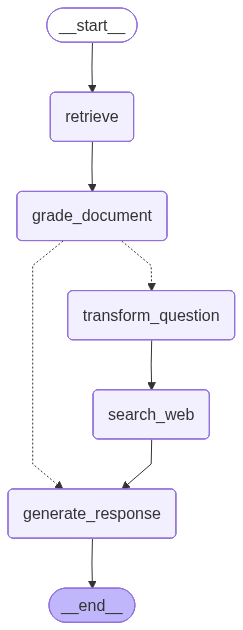

In [14]:
from langgraph.graph import StateGraph, START, END

workflow = StateGraph(GraphState)

# define nodes
workflow.add_node("retrieve", retrieve)
workflow.add_node("grade_document", grade_document)
workflow.add_node("transform_question", transform_question)
workflow.add_node("search_web", search_web)
workflow.add_node("generate_response", generate_response)

# build graph
workflow.add_edge(START, "retrieve")
workflow.add_edge("retrieve", "grade_document")
workflow.add_conditional_edges(
    "grade_document",
    decide_to_generate,
    {
        "transform_question": "transform_question",
        "generate_response": "generate_response",
    },
)
workflow.add_edge("transform_question", "search_web")
workflow.add_edge("search_web", "generate_response")
workflow.add_edge("generate_response", END)

# compile graph
graph = workflow.compile()

from IPython.display import Image
display(Image(graph.get_graph().draw_mermaid_png()))

In [15]:
graph.invoke({"question": "What is LangChain?"})

--- Retrieving documents ---
--- CHECK DOCUMENT RELEVANCE TO QUESTION ---
--- Document is not relevant to question ---
--- Document is not relevant to question ---
-- ASSESS GRADED DOCUMENTS ---
---DECISION: ALL DOCS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUESTION---
--- TRANSFORM QUESTION ---
--- SEARCHING WEB ---
--- Generating response ---


{'question': 'What is LangChain and how is it used in programming and AI development?',
 'generation': 'LangChain is an open-source framework that simplifies the development of applications using large language models (LLMs) by providing a standardized interface for integration with various tools. It allows developers to connect LLMs to external data sources, manage prompts, and create complex workflows efficiently. This framework is available for both Python and JavaScript, making it versatile for AI development.',
 'web_search': 'Yes',
 'documents': [Document(metadata={}, page_content='# Introduction to LangChain\n\nLast Updated : \n25 Aug, 2025\n\nSuggest changes\n\n12 Likes\n\nLangChain is an open-source framework designed to simplify the creation of applications using large language models (LLMs). It provides a standard interface for integrating with other tools and end-to-end chains for common applications. It helps AI developers connect LLMs such as GPT-4 with external data and 